In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models
from torch.nn import Module,Conv2d,MaxPool2d,Linear,Dropout,BatchNorm2d,ReLU,Sequential,Softmax
from torch.utils.data import random_split,DataLoader,Dataset,DataLoader
from torchvision import transforms,datasets,models
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.utils.data as data
from torch.nn import Embedding
import PIL.Image as Image
from warnings import filterwarnings
filterwarnings('ignore')

c:\Users\Dell\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Recurrent Text Generation

### Data preparation

In [2]:
filename = "source_water.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

In [3]:
# create mapping of unique chars to integers
chars = sorted(set(raw_text))
print("Unique chars: ",len(chars))

Unique chars:  51


In [4]:
char_to_int = {u:i for i,u in enumerate(chars)}
int_to_char = np.array(chars)
text_as_int = np.array([char_to_int[c] for c in raw_text])

print(raw_text[:15],"---> mapped to --->", text_as_int[:15])

water is a fund ---> mapped to ---> [44 22 41 26 39  0 30 40  0 22  0 27 42 35 25]


In [5]:
seq_length = 100
examples_per_epoch = len(raw_text)//(seq_length)

char_dataset = torch.tensor(text_as_int)
print(char_dataset)

for i in char_dataset:
    print(int_to_char[i.item()],end="")

tensor([44, 22, 41,  ..., 33, 46,  8], dtype=torch.int32)
water is a fundamental and indispensable element for life on earth, constituting the very essence of existence. its unique properties make it a substance like no other, playing a vital role in the sustenance and development of all living organisms. this essay explores the significance of water in various aspects of life, its physical and chemical properties, and the challenges associated with its conservation. the chemical formula of water, h2o, reveals a simple yet remarkable composition. its significance goes far beyond its molecular structure, as water is the cornerstone of life. water is a fundamental and indispensable element for life on earth, constituting the very essence of existence. its unique properties make it a substance like no other, playing a vital role in the sustenance and development of all living organisms. this essay explores the significance of water in various aspects of life, its physical and chemical pro

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

char_dataset = torch.tensor(char_dataset).to(device)

seq_length = 100  
sequences = DataLoader(TensorDataset(char_dataset[:-1], char_dataset[1:]), batch_size=seq_length, drop_last=True)

In [7]:
def split_input_target(chunk):
    input_text = chunk[0].float()
    target_text = chunk[1].float()
    return input_text, target_text

dataset = list(map(split_input_target, sequences))

print("Number of data sequences = ",len(dataset))

for i in dataset:
    print("Input =",i[0])
    print("Input shape =",i[0].shape)
    print("Target =",i[1])
    print("Target shape =",i[1].shape)
    break

Number of data sequences =  1391
Input = tensor([44., 22., 41., 26., 39.,  0., 30., 40.,  0., 22.,  0., 27., 42., 35.,
        25., 22., 34., 26., 35., 41., 22., 33.,  0., 22., 35., 25.,  0., 30.,
        35., 25., 30., 40., 37., 26., 35., 40., 22., 23., 33., 26.,  0., 26.,
        33., 26., 34., 26., 35., 41.,  0., 27., 36., 39.,  0., 33., 30., 27.,
        26.,  0., 36., 35.,  0., 26., 22., 39., 41., 29.,  6.,  0., 24., 36.,
        35., 40., 41., 30., 41., 42., 41., 30., 35., 28.,  0., 41., 29., 26.,
         0., 43., 26., 39., 46.,  0., 26., 40., 40., 26., 35., 24., 26.,  0.,
        36., 27.], device='cuda:0')
Input shape = torch.Size([100])
Target = tensor([22., 41., 26., 39.,  0., 30., 40.,  0., 22.,  0., 27., 42., 35., 25.,
        22., 34., 26., 35., 41., 22., 33.,  0., 22., 35., 25.,  0., 30., 35.,
        25., 30., 40., 37., 26., 35., 40., 22., 23., 33., 26.,  0., 26., 33.,
        26., 34., 26., 35., 41.,  0., 27., 36., 39.,  0., 33., 30., 27., 26.,
         0., 36., 35.,  

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
vocab_size = len(chars)
embedding_dim = 256
rnn_units = 1024

# Shuffle and batch the dataset using PyTorch DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
for data, target in dataloader:
    print("Data shape: ", data.shape)
    print("Target shape: ", target.shape)
    break

Data shape:  torch.Size([64, 100])
Target shape:  torch.Size([64, 100])


### Building model

In [9]:
class CharModel(nn.Module):
    
    def __init__(self, rnn_units, batch_size):
        super().__init__()
        self.rnn_units = rnn_units
        self.batch_size = batch_size
        self.lstm = nn.LSTM(num_layers=rnn_units, input_size=1, hidden_size=256)
        self.linear = nn.Linear(256, 100)
        
    def forward(self, x):
        x = x.reshape((self.batch_size, 100, 1)).float()
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x


model = CharModel(rnn_units=5, batch_size=BATCH_SIZE).to(device)


In [10]:
num_epochs = 1000
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    running_loss = 0.0
    for input_example_batch, target_example_batch in dataloader:

        optimizer.zero_grad()

        input_example_batch = input_example_batch.to(device).float() 
        target_example_batch = target_example_batch.to(device)  # Convert target to Long data type

        batch_predictions = model.forward(input_example_batch.to(device))

        loss = loss_function(batch_predictions, target_example_batch)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(dataloader)))
        

Epoch 0 - Training loss: 12494.153087797618
Epoch 1 - Training loss: 12420.987583705357
Epoch 2 - Training loss: 12421.109281994048
Epoch 3 - Training loss: 12424.24744233631
Epoch 4 - Training loss: 12421.819661458334
Epoch 5 - Training loss: 12416.581473214286
Epoch 6 - Training loss: 12414.233305431548
Epoch 7 - Training loss: 12413.015857514882
Epoch 8 - Training loss: 12413.329985119048
Epoch 9 - Training loss: 12411.672200520834
Epoch 10 - Training loss: 12410.162155877977
Epoch 11 - Training loss: 12410.712332589286
Epoch 12 - Training loss: 12409.097423735118
Epoch 13 - Training loss: 12410.255115327382
Epoch 14 - Training loss: 12406.024507068452
Epoch 15 - Training loss: 12407.909970238095
Epoch 16 - Training loss: 12404.62537202381
Epoch 17 - Training loss: 12404.875651041666
Epoch 18 - Training loss: 12405.353050595239
Epoch 19 - Training loss: 12407.416201636905
Epoch 20 - Training loss: 12408.80212983631
Epoch 21 - Training loss: 12407.381045386905
Epoch 22 - Training los

KeyboardInterrupt: 

In [ ]:
num = [44., 22., 41., 26., 39.,  0., 30., 40.,  0., 22.,  0., 27., 42., 35.,
        25., 22., 34., 26., 35., 41., 22., 33.,  0., 22., 35., 25.,  0., 30.,
        35., 25., 30., 40., 37., 26., 35., 40., 22., 23., 33., 26.,  0., 26.,
        33., 26., 34., 26., 35., 41.,  0., 27., 36., 39.,  0., 33., 30., 27.,
        26.,  0., 36., 35.,  0., 26., 22., 39., 41., 29.,  6.,  0., 24., 36.,
        35., 40., 41., 30., 41., 42., 41., 30., 35., 28.,  0., 41., 29., 26.,
         0., 43., 26., 39., 46.,  0., 26., 40., 40., 26., 35., 24., 26.,  0.,
        36., 27.]
text = ""
for i in num:
        text+=int_to_char[int(i)]
print(text)


water is a fundamental and indispensable element for life on earth, constituting the very essence of


## Image generator

In [ ]:
def split_string_into_five_words(input_string):
    words = input_string.split()
    result_strings = []

    for i in range(0, len(words), 5):
        five_words = ' '.join(words[i:i+5])
        result_strings.append(five_words)

    return result_strings

text = split_string_into_five_words(text)
text

['water is a fundamental and',
 'indispensable element for life on',
 'earth, constituting the very essence',
 'of']

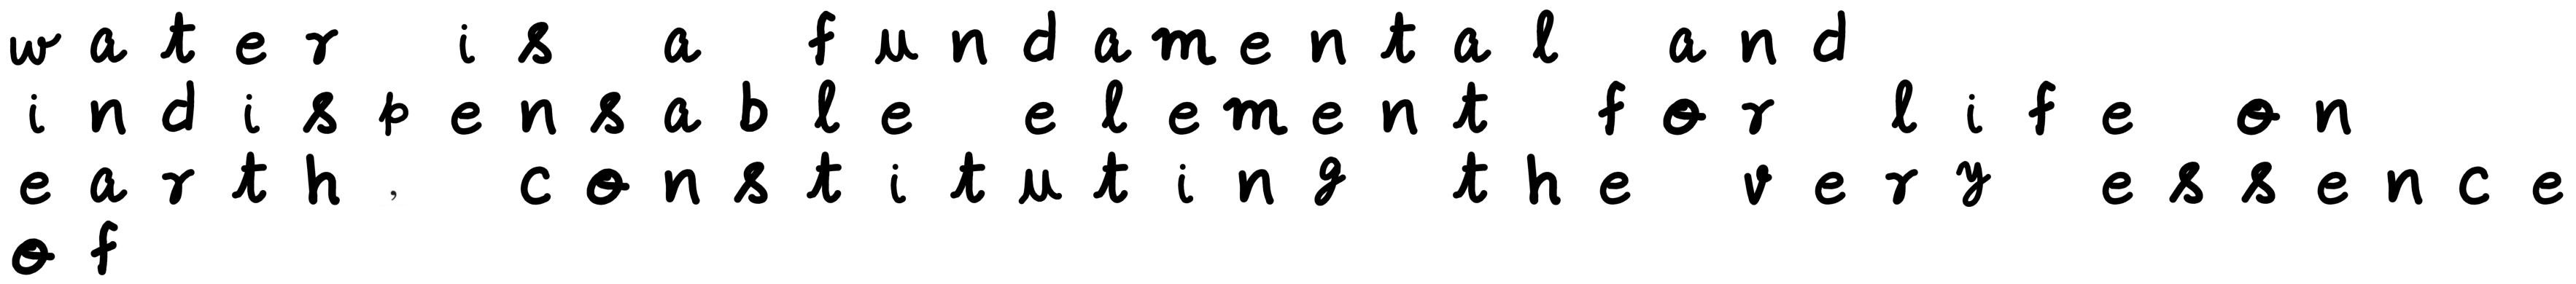

In [ ]:
def create_image1(sentences):
    '''
    Input - list of sentences(strings)
    Output - Image 
    Creates an image containing handwritten charaacaters from the text sentences.
    '''
    num_sentence = len(sentences)
    max_len = max([len(sentence) for sentence in sentences])

    symbols = ['.']

    fig, axes = plt.subplots(num_sentence, max_len, figsize=(max_len,num_sentence))
    plt.subplots_adjust(wspace=0, hspace=0)

    for j in range(num_sentence):

        sentence = sentences[j]

        chars = [char for char in sentence]
        chars.extend([' ' for i in range(max_len - len(sentence))])

        for i in range(len(chars)):

            if(chars[i]>='Z'):
                axes[j,i].imshow(Image.open('data/' + chars[i] + '_small.png'))

            elif(chars[i]==' '):
                axes[j,i].imshow(Image.open('data/space.png'))

            elif(chars[i] in symbols):
                axes[j,i].imshow(Image.open('data/space.png'))

            elif(chars[i] == '?'):
                axes[j,i].imshow(Image.open('data/question.jpg'))

            else:
                axes[j,i].imshow(Image.open('data/' + chars[i] + '.png'))

            axes[j,i].axis('off')

    fig.tight_layout(w_pad=-1,h_pad=1)
    return fig

from image_generation import create_image
create_image(text)
# img.savefig("generated/output.png")